import libraries

In [186]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
from torchmetrics.classification import BinaryJaccardIndex
from tqdm import tqdm

function to map polygon to image masks - training data

In [187]:
images_dir = "./dataset/train/images"
labels_dir = "./dataset/train/labels"
masks_dir = "./dataset/train/output_masks"
os.makedirs(masks_dir, exist_ok=True)

for img_file in os.listdir(images_dir):
    if not img_file.endswith(('.jpg', '.png')):
        continue
    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, os.path.splitext(img_file)[0] + '.txt')
    mask_path = os.path.join(masks_dir, os.path.splitext(img_file)[0] + '.png')
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load image {img_path}")
        continue
    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f:
                items = list(map(float, line.strip().split()))
                cls = int(items[0]) + 1
                points = np.array(items[1:]).reshape(-1, 2)
                points[:, 0] *= w
                points[:, 1] *= h
                points = points.astype(np.int32)
                cv2.fillPoly(mask, [points], cls)
    cv2.imwrite(mask_path, mask)

function to map polygon to image masks - validation data

In [188]:
images_dir = "./dataset/valid/images"
labels_dir = "./dataset/valid/labels"
masks_dir = "./dataset/valid/output_masks"
os.makedirs(masks_dir, exist_ok=True)

for img_file in os.listdir(images_dir):
    if not img_file.endswith(('.jpg', '.png')):
        continue
    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, os.path.splitext(img_file)[0] + '.txt')
    mask_path = os.path.join(masks_dir, os.path.splitext(img_file)[0] + '.png')
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load image {img_path}")
        continue
    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f:
                items = list(map(float, line.strip().split()))
                cls = int(items[0]) + 1
                points = np.array(items[1:]).reshape(-1, 2)
                points[:, 0] *= w
                points[:, 1] *= h
                points = points.astype(np.int32)
                cv2.fillPoly(mask, [points], cls)
    cv2.imwrite(mask_path, mask)

show example data

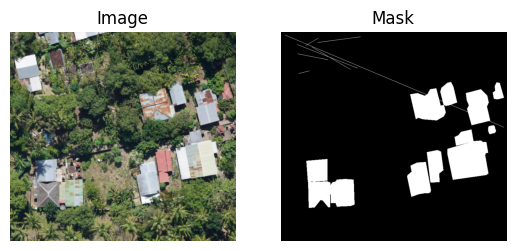

In [189]:
img = cv2.imread('./dataset/valid/images/Screenshot-2025-03-01-224236_png.rf.2b5295a45ee7ab530f027f63eafca4d1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread('./dataset/valid/output_masks/Screenshot-2025-03-01-224236_png.rf.2b5295a45ee7ab530f027f63eafca4d1.png', cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1); plt.imshow(img); plt.axis('off'); plt.title('Image')
plt.subplot(1,2,2); plt.imshow(mask, cmap='gray'); plt.axis('off'); plt.title('Mask')
plt.show()

segmentation dataset

In [190]:
import os
import cv2
import torch
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.files = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.images_dir, img_name)

        mask_name = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(self.masks_dir, mask_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask file not found or could not be opened: {mask_path}")

        mask = (mask == 1).astype('float32')
        
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.unsqueeze(0)

albumentation

In [191]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

valid_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(),
    ToTensorV2()
])

data load

In [192]:
train_dataset = SegmentationDataset(
    images_dir='./dataset/train/images',
    masks_dir='./dataset/train/output_masks',
    transform=train_transform
)
valid_dataset = SegmentationDataset(
    images_dir='./dataset/valid/images',
    masks_dir='./dataset/valid/output_masks',
    transform=valid_transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)

define model

In [194]:
from segmentation_models_pytorch.losses import JaccardLoss

model = smp.UnetPlusPlus(
    encoder_name="mobilenet_v2",        
    encoder_weights="imagenet",     
    in_channels=3,
    classes=1,                   
)
loss_fn = lambda logits, targets: 0.5 * nn.BCEWithLogitsLoss()(logits, targets) + 0.5 * JaccardLoss(mode='binary')(logits, targets)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

c:\Users\hg\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hg\.cache\huggingface\hub\models--smp-hub--mobilenet_v2.imagenet. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train the data

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
epochs_input = 15

train_losses = []
val_losses = []
ious = []

jaccard = BinaryJaccardIndex().to(device)
best_score = 0.0

for epoch in range(epochs_input):
    print(f"\nEpoch [{epoch+1}/{epochs_input}]")

    model.train()
    train_loss = 0.0
    for images, masks in tqdm(train_loader, desc="Training", leave=False):
        try:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)   
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        except Exception as e:
            print(f"Error in training batch: {e}")

    avg_train_loss = train_loss / len(train_loader)
    print(f"Training Loss: {avg_train_loss:.4f}")

    model.eval()
    jaccard.reset()
    val_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(valid_loader, desc="Validating", leave=False):
            try:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, masks)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs)
                preds = (preds > 0.5).int()
                true_masks = masks.int()

                jaccard.update(preds, true_masks)

            except Exception as e:
                print(f"Error in validation batch: {e}")


    avg_val_loss = val_loss / len(valid_loader)
    epoch_iou = jaccard.compute().item()
    print(f"Validation Loss: {avg_val_loss:.4f} | IoU: {epoch_iou:.4f}")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    ious.append(epoch_iou)

    if epoch_iou > best_score:
        best_score = epoch_iou
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Best model saved.")


Epoch [1/15]


Training Loss: 0.3136


Validation Loss: 0.4488 | IoU: 0.5792
✅ Best model saved.

Epoch [2/15]


Training Loss: 0.2215


Validation Loss: 0.4153 | IoU: 0.6032
✅ Best model saved.

Epoch [3/15]


Training Loss: 0.1982


Validation Loss: 0.4200 | IoU: 0.6144
✅ Best model saved.

Epoch [4/15]


Training Loss: 0.1848


Validation Loss: 0.3806 | IoU: 0.6207
✅ Best model saved.

Epoch [5/15]


Training Loss: 0.1835


Validation Loss: 0.3816 | IoU: 0.6200

Epoch [6/15]


Training Loss: 0.1734


Validation Loss: 0.4873 | IoU: 0.6185

Epoch [7/15]


Training Loss: 0.1653


Validation Loss: 0.3874 | IoU: 0.6348
✅ Best model saved.

Epoch [8/15]


Training Loss: 0.1604


Validation Loss: 0.3966 | IoU: 0.6390
✅ Best model saved.

Epoch [9/15]


Training Loss: 0.1595


Validation Loss: 0.4548 | IoU: 0.6323

Epoch [10/15]


Training Loss: 0.1563


Validation Loss: 0.3779 | IoU: 0.6403
✅ Best model saved.

Epoch [11/15]


Training Loss: 0.1488


Validation Loss: 0.4397 | IoU: 0.6354

Epoch [12/15]


Training Loss: 0.1438


Validation Loss: 0.4128 | IoU: 0.6409
✅ Best model saved.

Epoch [13/15]


Training Loss: 0.1494


Validation Loss: 0.4885 | IoU: 0.6384

Epoch [14/15]


Training Loss: 0.1422


Validation Loss: 0.4043 | IoU: 0.6407

Epoch [15/15]


Training Loss: 0.1435


Validation Loss: 0.3816 | IoU: 0.6442
✅ Best model saved.


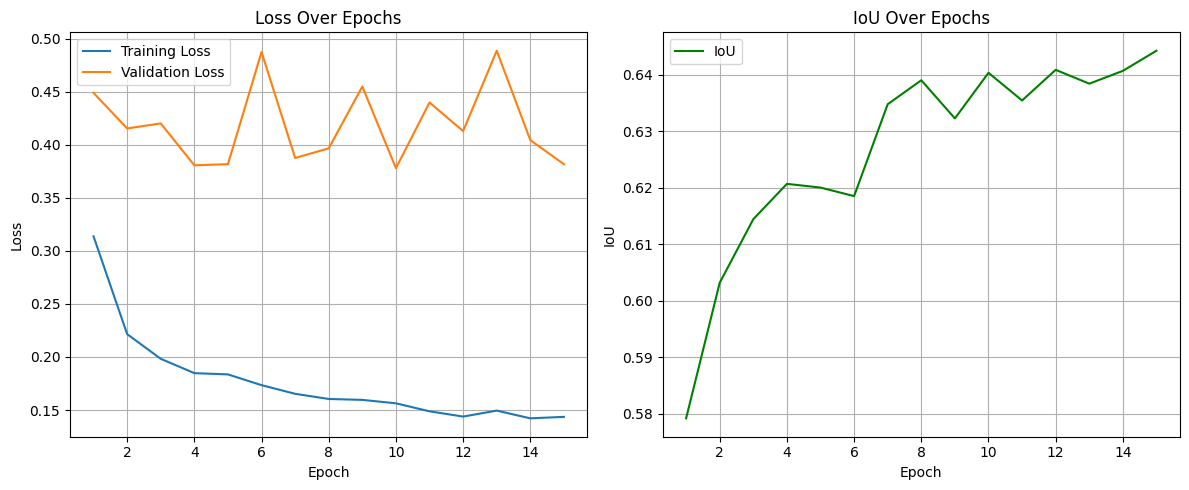

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, epochs_input + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, ious, label='IoU', color='green')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


load model

In [6]:
import os
import cv2
images_dir = "./dataset/test/images"
labels_dir = "./dataset/test/labels"
masks_dir = "./dataset/test/output_masks"
os.makedirs(masks_dir, exist_ok=True)

for img_file in os.listdir(images_dir):
    if not img_file.endswith(('.jpg', '.png')):
        continue

    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, os.path.splitext(img_file)[0] + '.txt')
    mask_path = os.path.join(masks_dir, os.path.splitext(img_file)[0] + '.png')

    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load image {img_path}")
        continue

    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f:
                items = list(map(float, line.strip().split()))
                cls = int(items[0]) + 1
                points = np.array(items[1:]).reshape(-1, 2)
                points[:, 0] *= w
                points[:, 1] *= h
                points = points.astype(np.int32)
                cv2.fillPoly(mask, [points], cls)

    cv2.imwrite(mask_path, mask)


In [9]:
import os
import cv2
import torch
from torch.utils.data import Dataset
import numpy as np

class TestSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __getitem__(self, idx):
        img_name = self.images[idx]  
        img_path = os.path.join(self.image_dir, img_name) 

        mask_name = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask file not found or could not be opened: {mask_path}")

        mask = (mask == 1).astype('float32')

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, torch.tensor(mask).unsqueeze(0)

    def __len__(self):
        return len(self.images)


In [11]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

test_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(),
    ToTensorV2()
])


c:\Users\hg\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from torch.utils.data import DataLoader
import torch
import segmentation_models_pytorch as smp

model = smp.UnetPlusPlus(
    encoder_name="mobilenet_v2",
    encoder_weights=None,
    in_channels=3,
    classes=1
)
model.load_state_dict(torch.load("best_model_mobilenetv2_iou_8826.pth", map_location="cpu"))
model.eval().to(device)

test_dataset = TestSegmentationDataset(
    image_dir="./dataset/test/images",
    mask_dir="./dataset/test/output_masks",
    transform=test_transform
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

from torchmetrics.classification import BinaryJaccardIndex

jaccard = BinaryJaccardIndex().to(device)
model.eval()
jaccard.reset()

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.float().to(device)

        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()
        jaccard.update(preds, masks.int())

test_iou = jaccard.compute().item()
print(f"✅ Test IoU: {test_iou:.4f}")


FileNotFoundError: Mask file not found or could not be opened: ./dataset/test/output_masks\5b0bb5a3-0031-4b46-b812-c24d838abaee.png

In [14]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def denormalize(image_tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return (image_tensor * std + mean).clamp(0, 1)

def calculate_density(pred_mask):
    """Calculate building density as ratio of building pixels to total pixels."""
    building_pixels = (pred_mask == 1).sum()
    total_pixels = pred_mask.size
    return building_pixels / total_pixels

def visualize_prediction_with_density(model, test_loader, device, num_samples=5):
    model.eval()
    model.to(device)

    count = 0
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            for i in range(images.size(0)):
                img_tensor = images[i].cpu()
                img_denorm = denormalize(img_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                image_np = img_denorm.permute(1, 2, 0).numpy()

                mask_np = masks[i].cpu().squeeze().numpy()
                pred_np = preds[i].cpu().squeeze().numpy()

                if mask_np.ndim != 2:
                    mask_np = mask_np[0]
                if pred_np.ndim != 2:
                    pred_np = pred_np[0]

                density = calculate_density(pred_np)
                print(f"Image {count+1} - Building Density: {density:.4f}")

                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.title("Original Image")
                plt.imshow(image_np)
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.title("Ground Truth")
                plt.imshow(mask_np, cmap='gray')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.title(f"Prediction\nDensity: {density:.4f}")
                plt.imshow(pred_np, cmap='gray')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                count += 1
                if count >= num_samples:
                    return


C:\Users\hg\AppData\Local\Temp\ipykernel_3784\3649539264.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask).unsqueeze(0)


Image 1 - Building Density: 0.2111


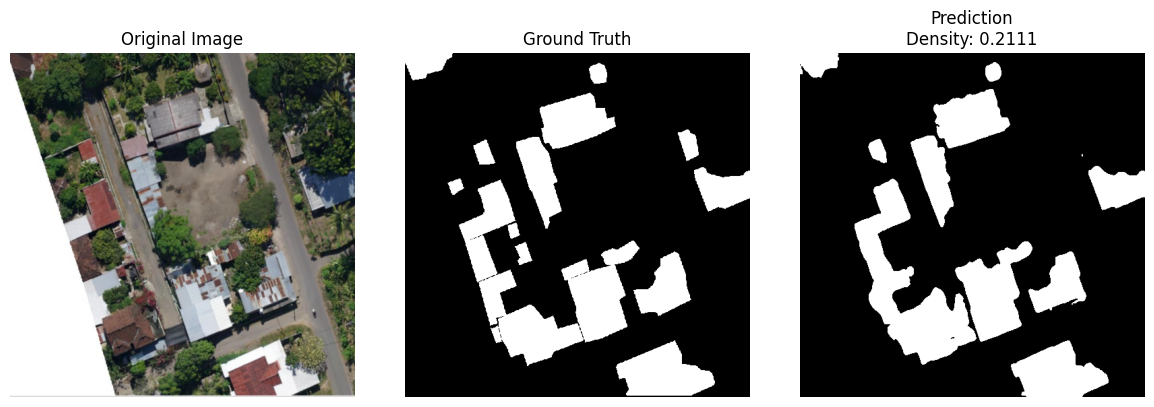

Image 2 - Building Density: 0.2245


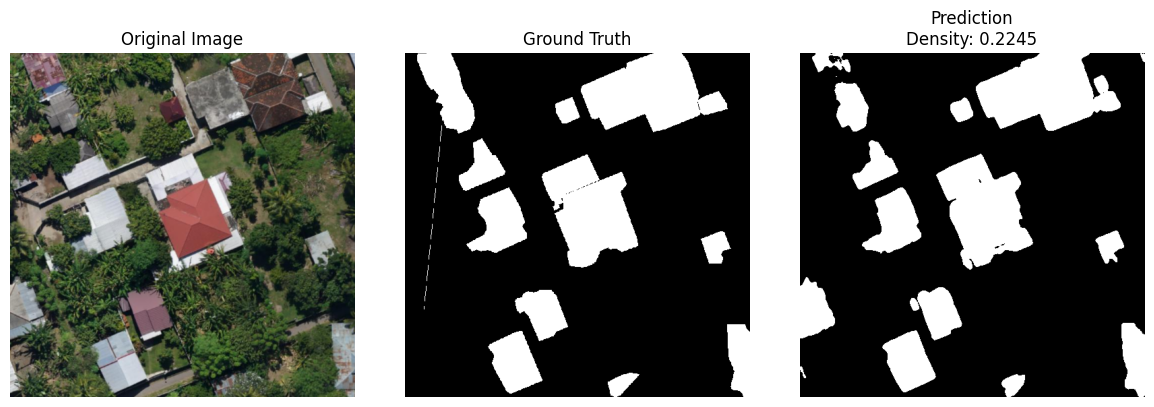

Image 3 - Building Density: 0.2111


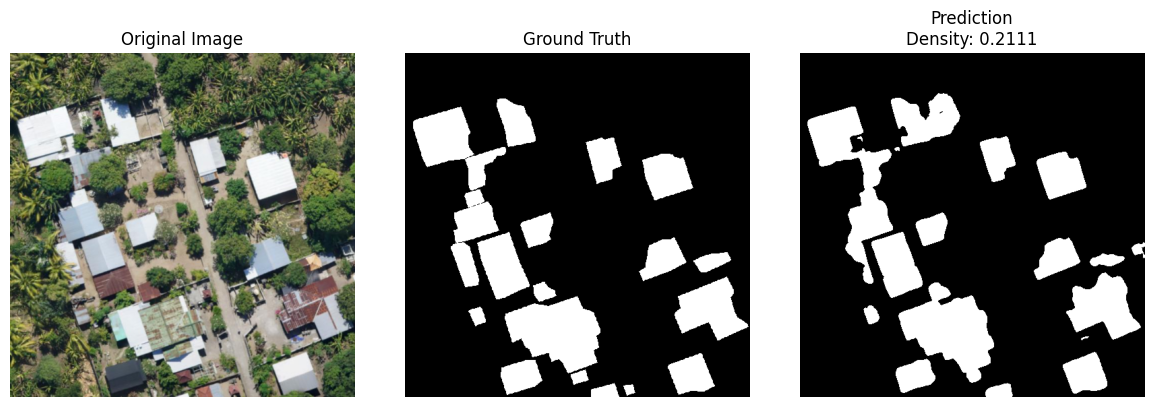

Image 4 - Building Density: 0.1749


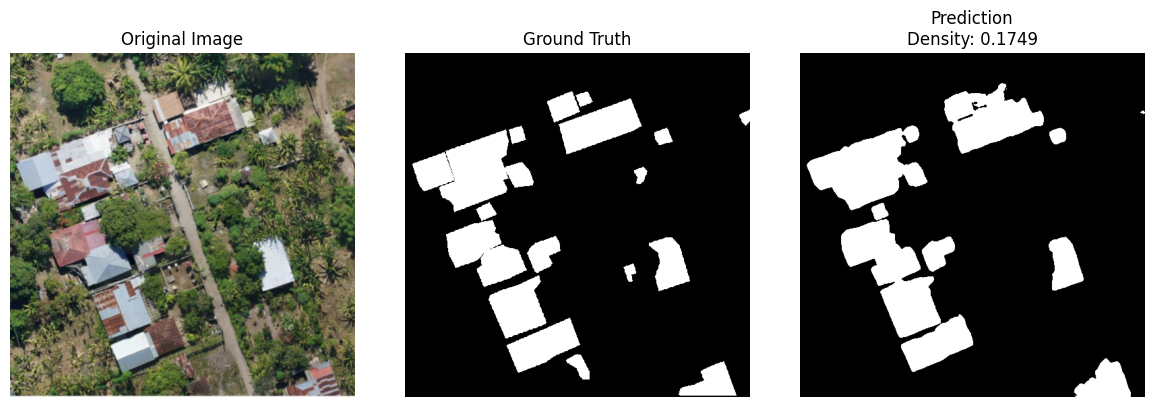

Image 5 - Building Density: 0.2348


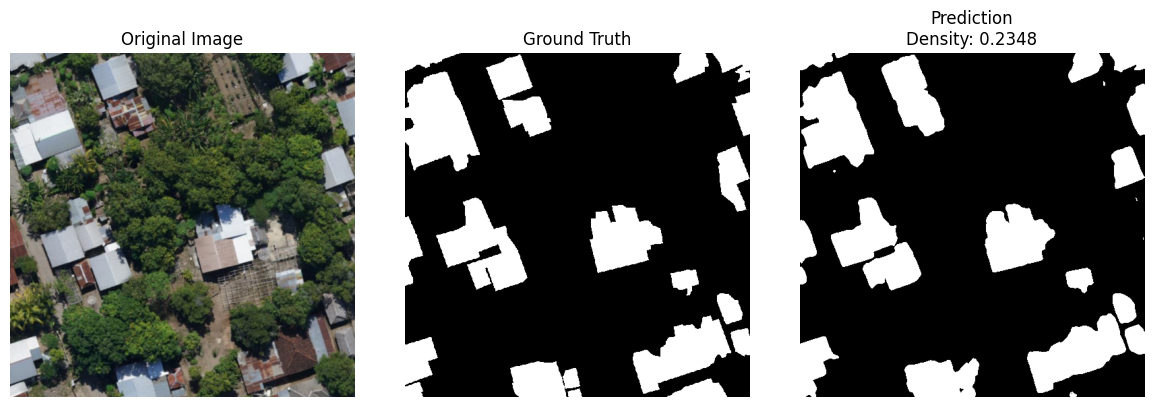

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
visualize_prediction_with_density(model, test_loader, device, num_samples=5)


predict images

In [ ]:
import os
import cv2
import torch
import matplotlib.pyplot as plt
import imageio

def predict_images_in_folder(model, folder_path, device, output_mask_folder, show=True):
    model.eval()
    model.to(device)

    os.makedirs(output_mask_folder, exist_ok=True)

    results = []

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        transformed = test_transform(image=image)
        input_tensor = transformed["image"].unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            pred = torch.sigmoid(output)
            pred = (pred > 0.5).float().cpu().squeeze().numpy()

        if pred.ndim != 2:
            pred = pred[0]

        density = (pred == 1).sum() / pred.size
        results.append((image_file, density))

        mask_filename = os.path.splitext(image_file)[0] + "_mask.tif"
        mask_path = os.path.join(output_mask_folder, mask_filename)

        pred_uint8 = (pred * 255).astype(np.uint8)
        imageio.imwrite(mask_path, pred_uint8)

        if show:
            plt.figure(figsize=(8, 4))
            density_string = ""
            if density > 0.7:
                density_string = "Rapat"
            elif 0.5 < density <= 0.7:
                density_string = "Sedang"
            elif 0.1 < density <= 0.5:
                density_string = "Jarang"
            else:
                density_string = "Non-bangunan"
                
            plt.suptitle(f"{image_file} - Density: {density:.4f} - {density_string}")

            plt.subplot(1, 2, 1)
            plt.title("Original Image")
            plt.imshow(image)
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title("Predicted Mask")
            plt.imshow(pred, cmap='gray')
            plt.axis('off')

            plt.show()

    return results


predict and save new images

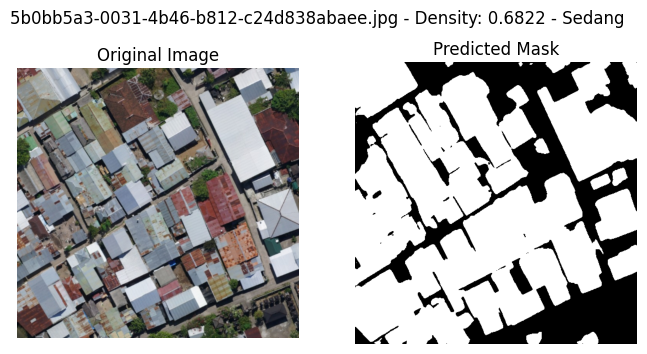

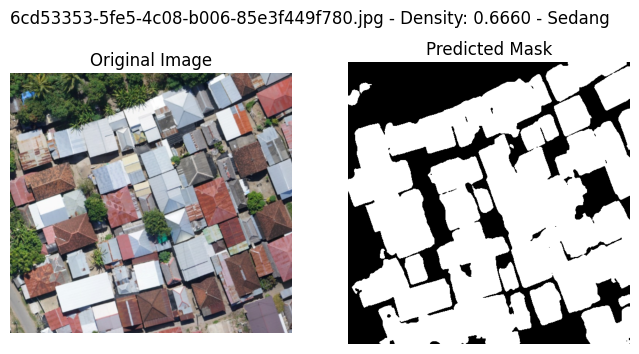

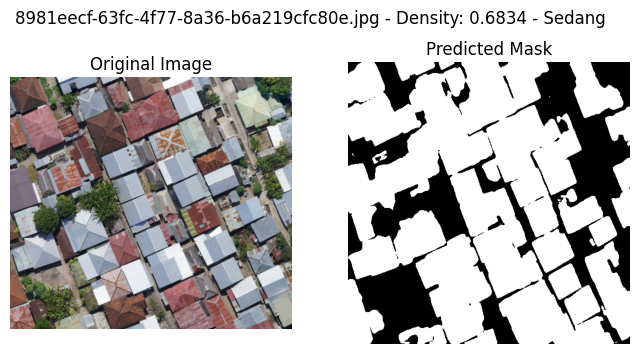

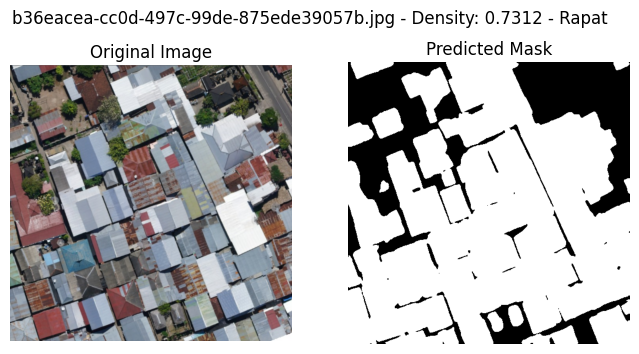

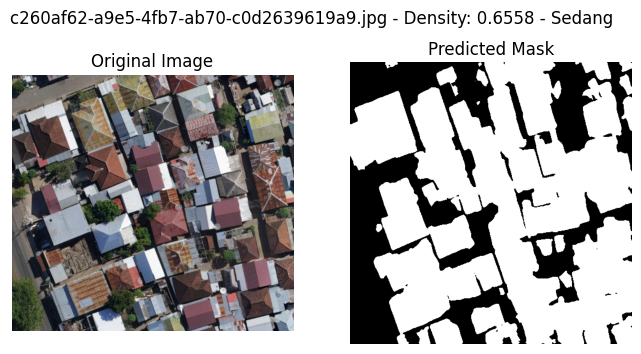

5b0bb5a3-0031-4b46-b812-c24d838abaee.jpg: Building Density = 0.6822
6cd53353-5fe5-4c08-b006-85e3f449f780.jpg: Building Density = 0.6660
8981eecf-63fc-4f77-8a36-b6a219cfc80e.jpg: Building Density = 0.6834
b36eacea-cc0d-497c-99de-875ede39057b.jpg: Building Density = 0.7312
c260af62-a9e5-4fb7-ab70-c0d2639619a9.jpg: Building Density = 0.6558


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

folder_path = "./input_photos"
output_folder = "./output_folder"

results = predict_images_in_folder(model, folder_path, device, output_folder)

for filename, density in results:
    print(f"{filename}: Building Density = {density:.4f}")